In [1]:
#Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
#Get the stock quote 
# df = web.DataReader('^BSESN', data_source='yahoo', start='2012-01-01', end='2021-06-29')
df = pd.read_csv("Dataset/Sensex.csv")
# droping null values
df = df.dropna()
#Show the data 
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,5209.540039,5384.660156,5209.540039,5375.109863,5375.109863,0.0
1,2000-01-04,5533.979980,5533.979980,5376.430176,5491.009766,5491.009766,0.0
2,2000-01-05,5265.089844,5464.350098,5184.479980,5357.000000,5357.000000,0.0
3,2000-01-06,5424.209961,5489.859863,5391.330078,5421.529785,5421.529785,0.0
4,2000-01-07,5358.279785,5463.250000,5330.580078,5414.479980,5414.479980,0.0
...,...,...,...,...,...,...,...
5121,2020-06-18,33371.519531,34276.011719,33371.519531,34208.050781,34208.050781,21200.0
5122,2020-06-19,34335.378906,34848.371094,34136.390625,34731.730469,34731.730469,27900.0
5123,2020-06-22,34892.031250,35213.519531,34794.398438,34911.320313,34911.320313,25100.0
5124,2020-06-23,35015.730469,35482.160156,34843.691406,35430.429688,35430.429688,25200.0


In [3]:
df.shape

(5040, 7)

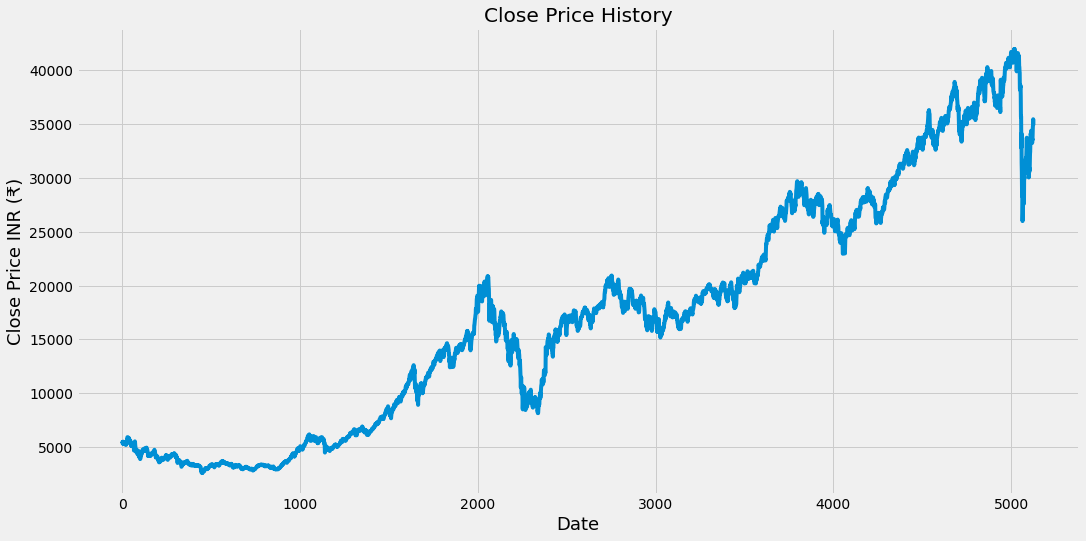

In [4]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price INR (₹)',fontsize=18)
plt.show()

In [5]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8)

In [6]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [7]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [8]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [9]:
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [10]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [11]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=5)

Epoch 1/5
3972/3972 [==============================] - 67s 14ms/step - loss: 0.0013
Epoch 2/5
3972/3972 [==============================] - 55s 14ms/step - loss: 2.0090e-04
Epoch 3/5
3972/3972 [==============================] - 56s 14ms/step - loss: 1.2014e-04
Epoch 4/5
3972/3972 [==============================] - 58s 15ms/step - loss: 9.5592e-05
Epoch 5/5
3972/3972 [==============================] - 58s 15ms/step - loss: 8.1277e-05


In [13]:
#Save the model
model.save("Sensex_Prediction_model", save_format='h5')

In [14]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [15]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)

In [16]:
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [17]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling

In [18]:
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

1708.7076769245034

<ipython-input-19-571b4eb24035>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


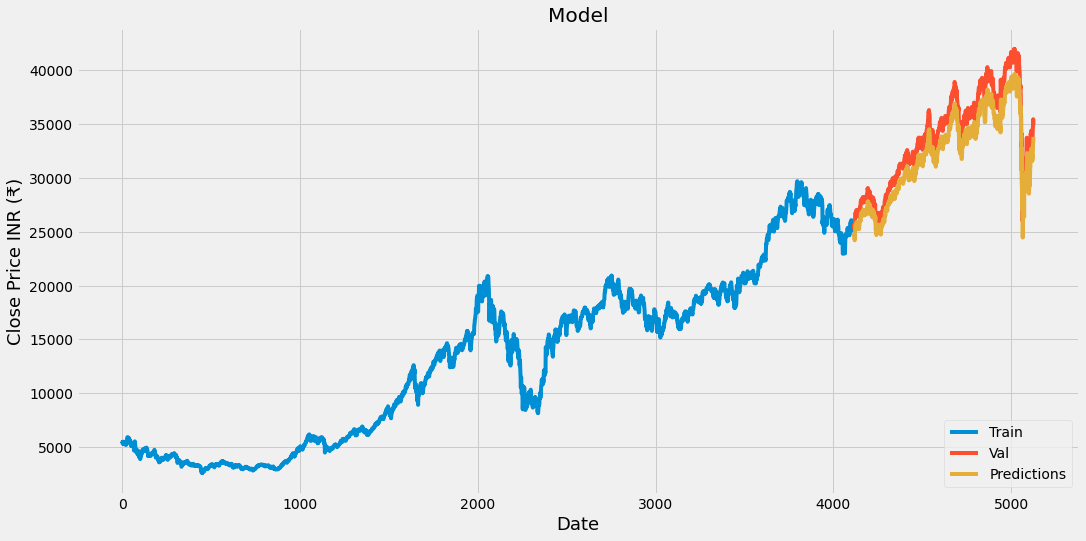

In [19]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price INR (₹)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.savefig('Sensex_Predicted_Graph.png')
plt.show()

In [20]:
#Show the valid and predicted prices
valid

,Close,Predictions
4115,25773.609375,24622.107422
4116,25704.609375,24738.169922
4117,25399.720703,24650.798828
4118,25301.900391,24328.441406
4119,25230.359375,24257.072266
...,...,...
5121,34208.050781,31905.617188
5122,34731.730469,32706.943359
5123,34911.320313,33158.386719
5124,35430.429688,33258.316406
